# Scaling

In [1]:
from imports import *

# set columnns display format
pd.set_option('display.max_columns', None)
# default pandas decimal number display format
# pd.options.display.float_format = '{:20,.3f}'.format

In [2]:
# import raw, messy data
df = acquire.get_zillow_data()

In [3]:
df = prepare.prep_zillow(df)

In [5]:
# Copy a new dataframe to perform feature engineering
scaled_df = df.copy()

# Initiate MinMaxScaler
scaler = MinMaxScaler()

# Fit numerical features to scaler
scaler.fit(scaled_df[['bathrooms', 'bedrooms', 'total_sqft', 'living_sqft', 'full_bath',
       'latitude', 'longitude', 'lot_sqft', 'roomcnt',
       'structure_value', 'assessed_value', 'land_value', 'taxamount', 'age']])

# Set the features to transformed value
scaled_df[['bathrooms', 'bedrooms', 'total_sqft', 'living_sqft', 'full_bath',
       'latitude', 'longitude', 'lot_sqft', 'roomcnt',
       'structure_value', 'assessed_value', 'land_value', 'taxamount', 'age']] = scaler.transform(scaled_df[['bathrooms', 'bedrooms', 'total_sqft', 'living_sqft', 'full_bath',
       'latitude', 'longitude', 'lot_sqft', 'roomcnt',
       'structure_value', 'assessed_value', 'land_value', 'taxamount', 'age']])

# Split the scaled data into train, validate, test
train, validate, test = prepare.split(scaled_df)

# # Split each dataset into X, y
# cols = ['bathrooms', 'bedrooms', 'total_sqft', 'living_sqft', 'full_bath',
#         'latitude', 'longitude', 'lot_sqft', 'roomcnt', 'zip_code',
#         'structure_value', 'assessed_value', 'land_value', 'taxamount', 'age', 'county_Los Angeles',
#         'county_Orange', 'county_Ventura']
# X_train = s_train[cols]
# y_train = s_train.logerror
# X_validate = s_validate[cols] 
# y_validate = s_validate.logerror
# X_test = s_test[cols]
# y_test = s_test.logerror

In [7]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'total_sqft', 'living_sqft',
       'full_bath', 'latitude', 'longitude', 'lot_sqft', 'roomcnt',
       'structure_value', 'assessed_value', 'land_value', 'taxamount',
       'logerror', 'age', 'taxrate', 'county', 'transaction_month',
       'county_Los Angeles', 'county_Orange', 'county_Ventura', 'zip_code'],
      dtype='object')

# Clustering

## Approaches / Clusters to try:
- **Location** (`latitude`, `longitude`, `county`, `zip_code`)
- **Age** (`age`)
- **Area** (`total_sqft`, `living_sqft`, `lot_sqft`)
- **Size (rooms)** (`bedrooms`, `bathrooms`, `full_bath`, `roomcnt`)
- **Value** (`structure_value`, `assessed_value`,`land_valu`, `taxamount`)

## Location Cluster

**latitude, longitude, zip_code, k=3**

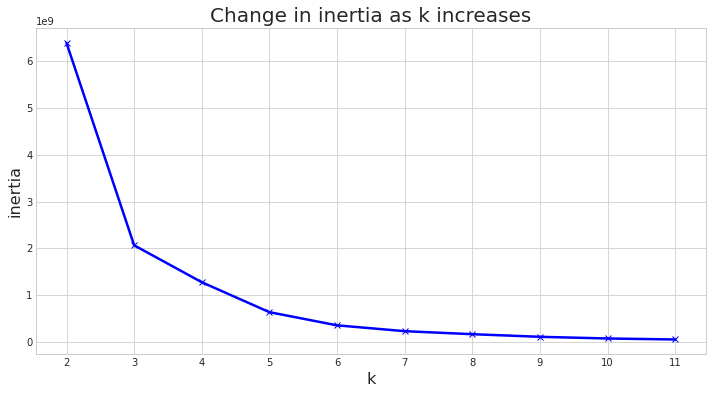

In [6]:
# Select features for cluster
cluster_vars = train[['latitude', 'longitude', 'zip_code']]
# Using the elbow method to visually select a good value for k.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(cluster_vars).inertia_ for k in range(2, 12)}).plot(marker='x', color = 'blue', linewidth = 2.5)
    plt.xticks(range(2, 12))
    plt.xlabel('k', fontsize = 16)
    plt.ylabel('inertia', fontsize = 16)
    plt.title('Change in inertia as k increases', fontsize = 20)

This graph seems to show a drop off in inertia around **k==4**

**k==3** is the ideal cluster number

In [7]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_vars)

location_clusters = kmeans.predict(cluster_vars)
train['location_clusters_a'] = location_clusters
train.head()

,parcelid,bathrooms,bedrooms,total_sqft,living_sqft,full_bath,latitude,longitude,lot_sqft,roomcnt,structure_value,assessed_value,land_value,taxamount,logerror,age,taxrate,county,transaction_month,county_Los Angeles,county_Orange,county_Ventura,zip_code,location_clusters_a
40935,11852584,0.166667,0.333333,0.223146,0.223146,0.166667,0.479513,0.722402,0.142086,0.000000,0.224745,0.369544,0.220483,0.127198,0.008887,0.420290,1.512845,Los Angeles,7,1,0,0,90640,0
42852,12470054,0.166667,0.333333,0.115889,0.115889,0.166667,0.354453,0.689652,0.131308,0.000000,0.058301,0.161524,0.149972,0.053462,-0.032206,0.442029,1.306395,Los Angeles,8,1,0,0,90712,0
29696,14033839,0.166667,0.333333,0.155691,0.155691,0.166667,0.274714,0.811325,0.130391,0.583333,0.114497,0.445096,0.387699,0.113596,-0.003708,0.333333,1.141333,Orange,6,0,1,0,92708,1
35860,17194875,0.250000,0.500000,0.418958,0.418958,0.166667,0.592341,0.264595,0.202229,0.666667,0.643307,0.847675,0.352690,0.200244,0.007720,0.094203,1.095202,Ventura,7,0,0,1,91320,2
28005,11903595,0.166667,0.333333,0.187020,0.187020,0.166667,0.521157,0.693129,0.118126,0.000000,0.121888,0.445040,0.381510,0.118994,0.033695,0.471014,1.195283,Los Angeles,6,1,0,0,91803,2


In [9]:
train.groupby('location_clusters_a').logerror.mean()

location_clusters_a
0    0.012651
1    0.021930
2    0.017138
Name: logerror, dtype: float64

<AxesSubplot:xlabel='location_clusters_a', ylabel='logerror'>

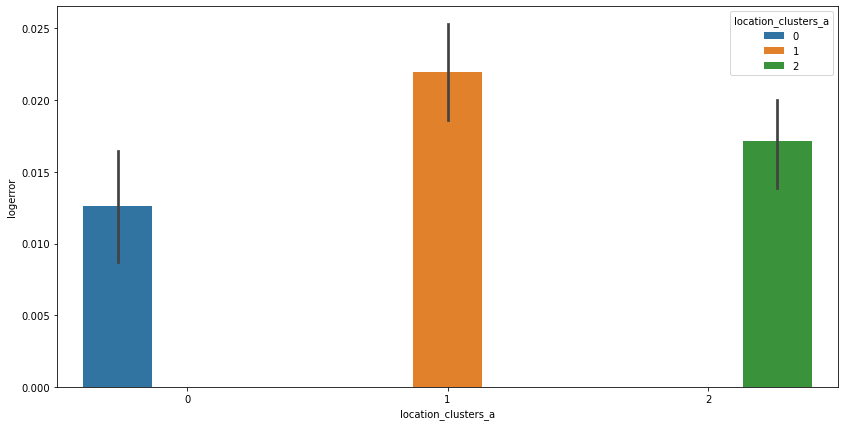

In [40]:
plt.figure(figsize = (14,7))
sns.barplot(x='location_clusters_a', y=
            'logerror', hue='location_clusters_a', data = train)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

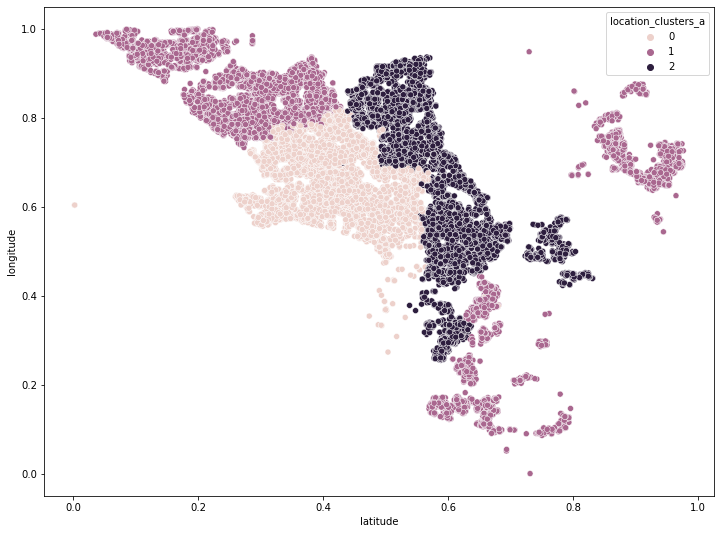

In [20]:
plt.figure(figsize = (12,9))
sns.scatterplot(x='latitude', y='longitude', hue = 'location_clusters_a', data=train)

### ANOVA Test
**Set Hypothesis**

$H_{0}$: Logerror of three different clusters are all equal.

$H_{a}$: Logerror of three different clusters are not all equal.


**Verify Assumptions**

- Normal: Yes
- Independent: Yes
- Variance: False

In [11]:
# Set alpha
alpha = 0.05
cluster0 = train[train.location_clusters_a==0].logerror
cluster1 = train[train.location_clusters_a==1].logerror
cluster2 = train[train.location_clusters_a==2].logerror
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cluster0, cluster1, cluster2)
if p < alpha:
    print("We reject H0.")
    print(Fore.BLUE + '\nMean of 3 location clusters are not all equal. ')
else:
    print("We fail to reject H0")

We reject H0.

Mean of 3 location clusters are not all equal. 


**zip_code, county(dummies), k=3**

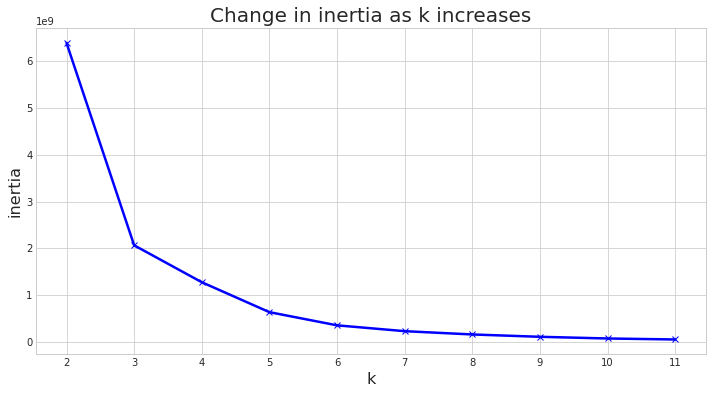

In [22]:
# Select features for cluster
cluster_vars = train[['county_Los Angeles', 'county_Orange', 'zip_code']]
# Using the elbow method to visually select a good value for k.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(cluster_vars).inertia_ for k in range(2, 12)}).plot(marker='x', color = 'blue', linewidth = 2.5)
    plt.xticks(range(2, 12))
    plt.xlabel('k', fontsize = 16)
    plt.ylabel('inertia', fontsize = 16)
    plt.title('Change in inertia as k increases', fontsize = 20)

In [31]:
train.head()

,parcelid,bathrooms,bedrooms,total_sqft,living_sqft,full_bath,latitude,longitude,lot_sqft,roomcnt,structure_value,assessed_value,land_value,taxamount,logerror,age,taxrate,county,transaction_month,county_Los Angeles,county_Orange,county_Ventura,zip_code,location_clusters_a,location_clusters_b
40935,11852584,0.166667,0.333333,0.223146,0.223146,0.166667,0.479513,0.722402,0.142086,0.000000,0.224745,0.369544,0.220483,0.127198,0.008887,0.420290,1.512845,Los Angeles,7,1,0,0,90640,0,1
42852,12470054,0.166667,0.333333,0.115889,0.115889,0.166667,0.354453,0.689652,0.131308,0.000000,0.058301,0.161524,0.149972,0.053462,-0.032206,0.442029,1.306395,Los Angeles,8,1,0,0,90712,0,1
29696,14033839,0.166667,0.333333,0.155691,0.155691,0.166667,0.274714,0.811325,0.130391,0.583333,0.114497,0.445096,0.387699,0.113596,-0.003708,0.333333,1.141333,Orange,6,0,1,0,92708,1,2
35860,17194875,0.250000,0.500000,0.418958,0.418958,0.166667,0.592341,0.264595,0.202229,0.666667,0.643307,0.847675,0.352690,0.200244,0.007720,0.094203,1.095202,Ventura,7,0,0,1,91320,2,0
28005,11903595,0.166667,0.333333,0.187020,0.187020,0.166667,0.521157,0.693129,0.118126,0.000000,0.121888,0.445040,0.381510,0.118994,0.033695,0.471014,1.195283,Los Angeles,6,1,0,0,91803,2,0


In [23]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_vars)

location_clusters = kmeans.predict(cluster_vars)
train['location_clusters_b'] = location_clusters
train.groupby('location_clusters_b').logerror.mean()

location_clusters_b
0    0.017138
1    0.012651
2    0.021930
Name: logerror, dtype: float64

<AxesSubplot:xlabel='location_clusters_b', ylabel='logerror'>

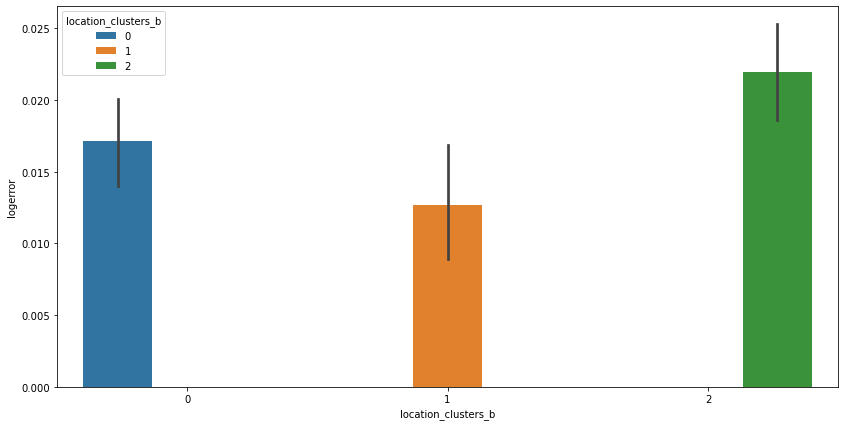

In [28]:
plt.figure(figsize = (14,7))
sns.barplot(x='location_clusters_b', y=
            'logerror', hue='location_clusters_b', data = train)

### ANOVA Test
**Set Hypothesis**

$H_{0}$: Logerror of three different clusters are all equal.

$H_{a}$: Logerror of three different clusters are not all equal.


**Verify Assumptions**

- Normal: Yes
- Independent: Yes
- Variance: False

In [30]:
# Set alpha
alpha = 0.05
cluster0 = train[train.location_clusters_b==0].logerror
cluster1 = train[train.location_clusters_b==1].logerror
cluster2 = train[train.location_clusters_b==2].logerror
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cluster0, cluster1, cluster2)
if p < alpha:
    print("We reject H0.")
    print(Fore.BLUE + '\nMean of 3 location clusters are not all equal. ')
else:
    print("We fail to reject H0")

We reject H0.

Mean of 3 location clusters are not all equal. 


**zip_code, county(dummies), k=4**

In [32]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=4)
kmeans.fit(cluster_vars)
cluster_vars = train[['county_Los Angeles', 'county_Orange', 'zip_code']]
location_clusters = kmeans.predict(cluster_vars)
train['location_clusters_c'] = location_clusters
train.groupby('location_clusters_c').logerror.mean()

location_clusters_c
0    0.008855
1    0.012651
2    0.017138
3    0.024821
Name: logerror, dtype: float64

<AxesSubplot:xlabel='location_clusters_c', ylabel='logerror'>

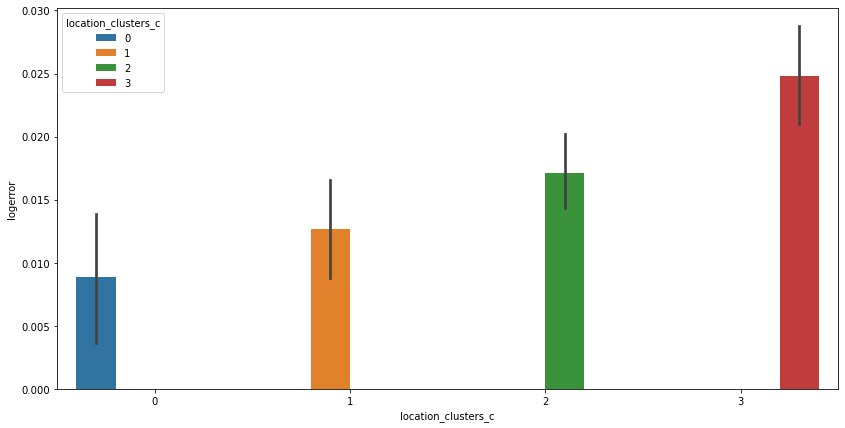

In [34]:
plt.figure(figsize = (14,7))
sns.barplot(x='location_clusters_c', y=
            'logerror', hue='location_clusters_c', data = train)

**zip_code, county(dummies), k=5**

In [35]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=5)
kmeans.fit(cluster_vars)
cluster_vars = train[['county_Los Angeles', 'county_Orange', 'zip_code']]
location_clusters = kmeans.predict(cluster_vars)
train['location_clusters_d'] = location_clusters
train.groupby('location_clusters_d').logerror.mean()

location_clusters_d
0    0.018453
1    0.024821
2    0.004366
3    0.018617
4    0.008855
Name: logerror, dtype: float64

<AxesSubplot:xlabel='location_clusters_d', ylabel='logerror'>

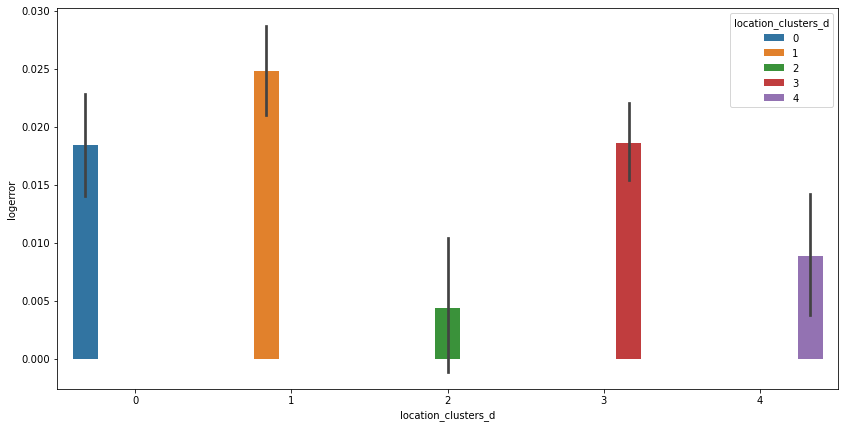

In [36]:
plt.figure(figsize = (14,7))
sns.barplot(x='location_clusters_d', y=
            'logerror', hue='location_clusters_d', data = train)

**latitude, longitude, conuty(dummies), k=3**

In [37]:
cluster_vars = train[['county_Los Angeles', 'county_Orange', 'latitude', 'longitude']]

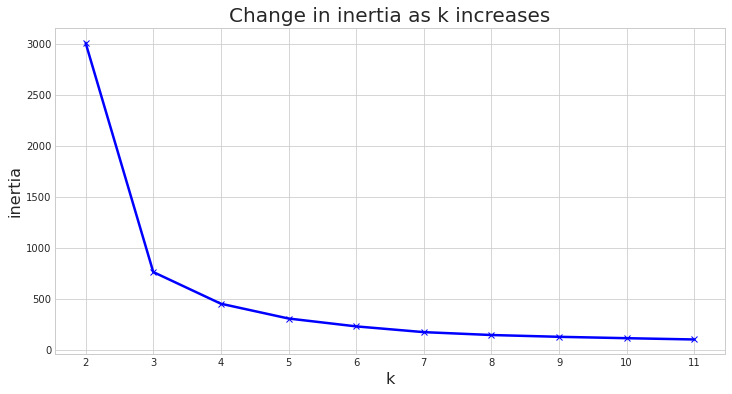

In [38]:
# Using the elbow method to visually select a good value for k.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(cluster_vars).inertia_ for k in range(2, 12)}).plot(marker='x', color = 'blue', linewidth = 2.5)
    plt.xticks(range(2, 12))
    plt.xlabel('k', fontsize = 16)
    plt.ylabel('inertia', fontsize = 16)
    plt.title('Change in inertia as k increases', fontsize = 20)

In [39]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_vars)
cluster_vars = train[['county_Los Angeles', 'county_Orange', 'latitude', 'longitude']]
location_clusters = kmeans.predict(cluster_vars)
train['location_clusters_e'] = location_clusters
train.groupby('location_clusters_e').logerror.mean()

location_clusters_e
0    0.013415
1    0.027825
2    0.016211
Name: logerror, dtype: float64

<AxesSubplot:xlabel='location_clusters_e', ylabel='logerror'>

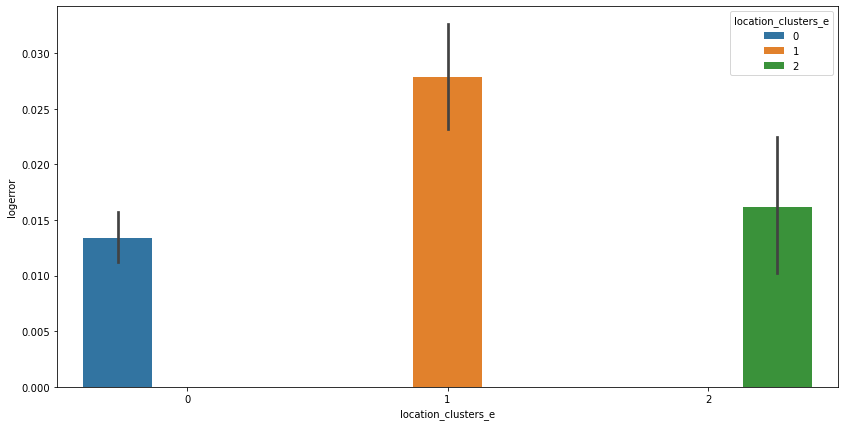

In [41]:
plt.figure(figsize = (14,7))
sns.barplot(x='location_clusters_e', y=
            'logerror', hue='location_clusters_e', data = train)

In [42]:
# Set alpha
alpha = 0.05
cluster0 = train[train.location_clusters_e==0].logerror
cluster1 = train[train.location_clusters_e==1].logerror
cluster2 = train[train.location_clusters_e==2].logerror
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cluster0, cluster1, cluster2)
if p < alpha:
    print("We reject H0.")
    print(Fore.BLUE + '\nMean of 3 location clusters are not all equal. ')
else:
    print("We fail to reject H0")

We reject H0.

Mean of 3 location clusters are not all equal. 


**latitude, longitude, conuty(dummies), k=4**

In [43]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=4)
kmeans.fit(cluster_vars)
cluster_vars = train[['county_Los Angeles', 'county_Orange', 'latitude', 'longitude']]
location_clusters = kmeans.predict(cluster_vars)
train['location_clusters_f'] = location_clusters
train.groupby('location_clusters_f').logerror.mean()

location_clusters_f
0    0.014355
1    0.027825
2    0.016211
3    0.012869
Name: logerror, dtype: float64

<AxesSubplot:xlabel='location_clusters_f', ylabel='logerror'>

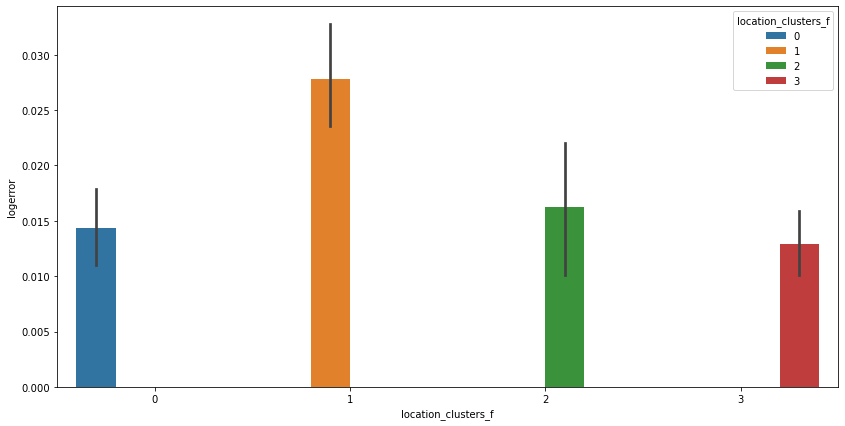

In [44]:
plt.figure(figsize = (14,7))
sns.barplot(x='location_clusters_f', y=
            'logerror', hue='location_clusters_f', data = train)

***

## Age Cluster

**age, k=3**

In [45]:
cluster_vars = train[['age']]

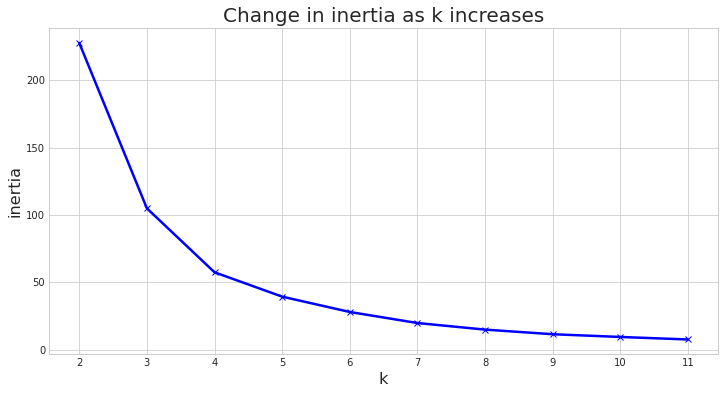

In [46]:
# Using the elbow method to visually select a good value for k.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(cluster_vars).inertia_ for k in range(2, 12)}).plot(marker='x', color = 'blue', linewidth = 2.5)
    plt.xticks(range(2, 12))
    plt.xlabel('k', fontsize = 16)
    plt.ylabel('inertia', fontsize = 16)
    plt.title('Change in inertia as k increases', fontsize = 20)

In [47]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_vars)
cluster_vars = train[['age']]
age_clusters = kmeans.predict(cluster_vars)
train['age_clusters_a'] = age_clusters
train.groupby('location_clusters_a').logerror.mean()

location_clusters_a
0    0.012651
1    0.021930
2    0.017138
Name: logerror, dtype: float64

<AxesSubplot:xlabel='age', ylabel='logerror'>

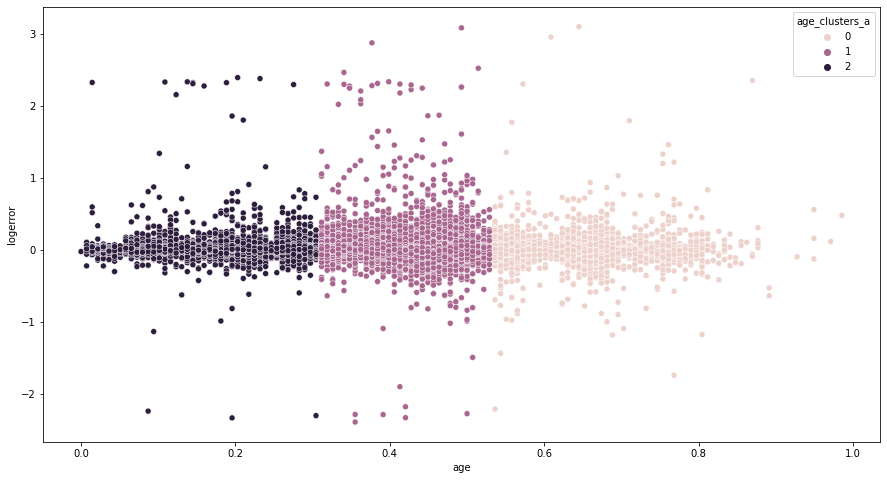

In [50]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='age', y='logerror', hue='age_clusters_a', data=train)

In [52]:
# Set alpha
alpha = 0.05
cluster0 = train[train.age_clusters_a==0].logerror
cluster1 = train[train.age_clusters_a==1].logerror
cluster2 = train[train.age_clusters_a==2].logerror
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cluster0, cluster1, cluster2)
if p < alpha:
    print("We reject H0.")
    print(Fore.BLUE + '\nMean of 3 location clusters are not all equal. ')
else:
    print("We fail to reject H0")

We reject H0.

Mean of 3 location clusters are not all equal. 


<AxesSubplot:xlabel='area_clusters_a', ylabel='logerror'>

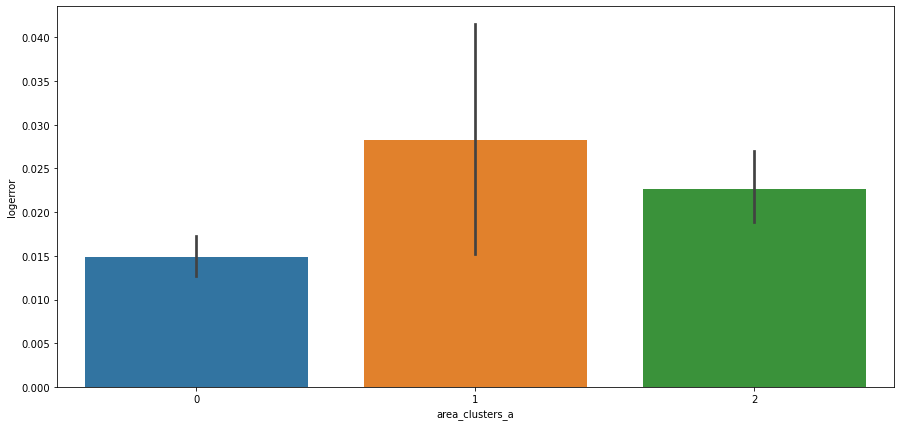

In [83]:
plt.figure(figsize = (15,7))
sns.barplot(x='area_clusters_a', y='logerror', data = train)

<span style='background :yellow' >**age, k=4**</span>

In [54]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=4)
kmeans.fit(cluster_vars)
cluster_vars = train[['age']]
age_clusters = kmeans.predict(cluster_vars)
train['age_clusters_b'] = age_clusters
train.groupby('age_clusters_b').logerror.mean()

age_clusters_b
0    0.015724
1    0.017033
2    0.023436
3    0.009459
Name: logerror, dtype: float64

<AxesSubplot:xlabel='age', ylabel='logerror'>

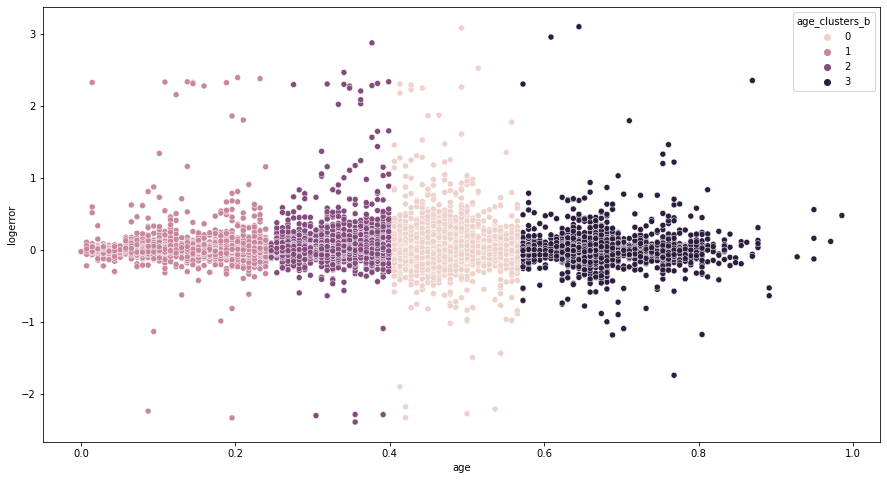

In [55]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='age', y='logerror', hue='age_clusters_b', data=train)

<AxesSubplot:xlabel='age_clusters_b', ylabel='logerror'>

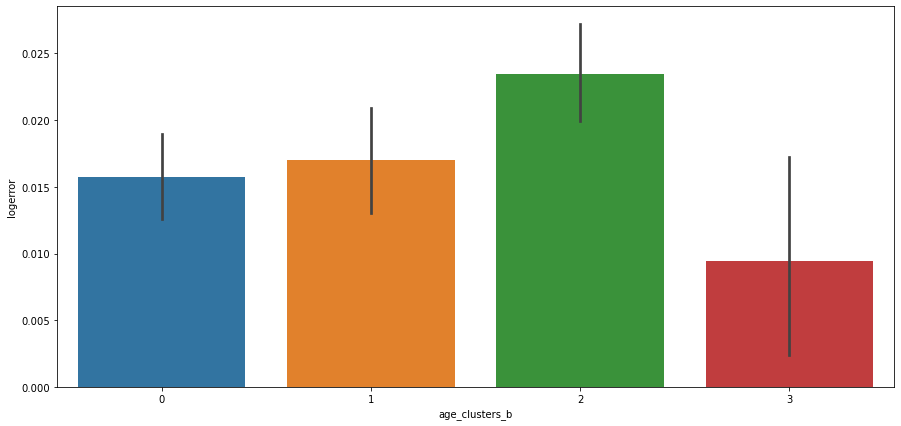

In [82]:
plt.figure(figsize = (15,7))
sns.barplot(x='age_clusters_b', y='logerror', data = train)

<span style='background :yellow' >**Area: total_sqft, lot_sqft, k==3**</span>

In [59]:
cluster_vars = train[['total_sqft', 'lot_sqft']]

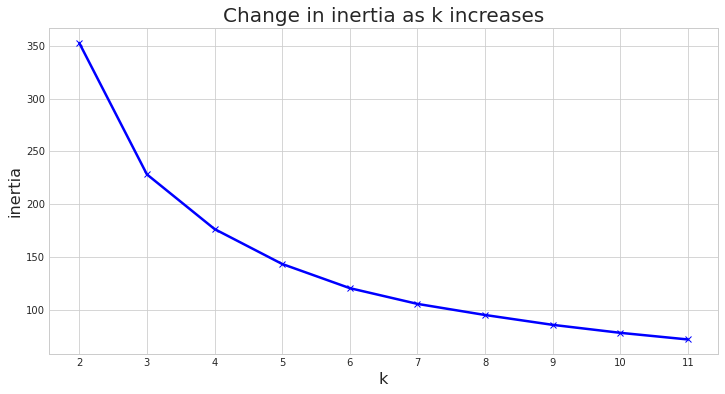

In [60]:
# Using the elbow method to visually select a good value for k.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(cluster_vars).inertia_ for k in range(2, 12)}).plot(marker='x', color = 'blue', linewidth = 2.5)
    plt.xticks(range(2, 12))
    plt.xlabel('k', fontsize = 16)
    plt.ylabel('inertia', fontsize = 16)
    plt.title('Change in inertia as k increases', fontsize = 20)

In [62]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_vars)
cluster_vars = train[['total_sqft', 'lot_sqft']]
area_clusters = kmeans.predict(cluster_vars)
train['area_clusters_a'] = area_clusters
train.groupby('area_clusters_a').logerror.mean()

area_clusters_a
0    0.014898
1    0.028238
2    0.022662
Name: logerror, dtype: float64

<AxesSubplot:xlabel='area_clusters_a', ylabel='logerror'>

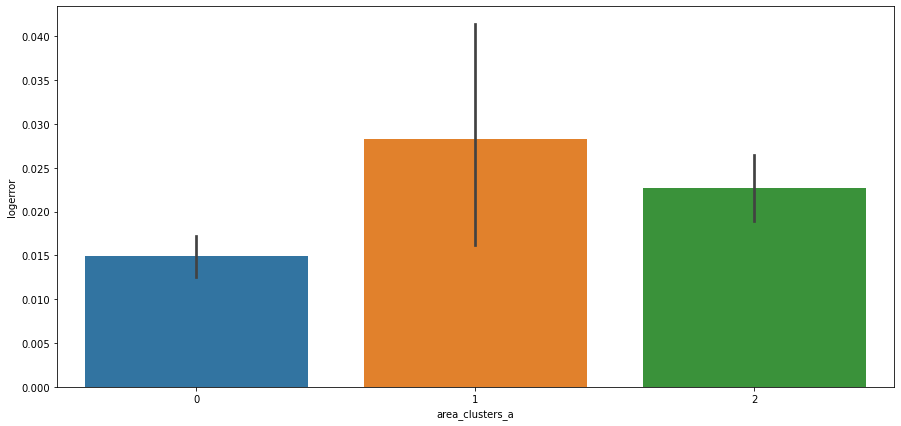

In [81]:
plt.figure(figsize = (15,7))
sns.barplot(x='area_clusters_a', y='logerror', data = train)

<AxesSubplot:xlabel='total_sqft', ylabel='lot_sqft'>

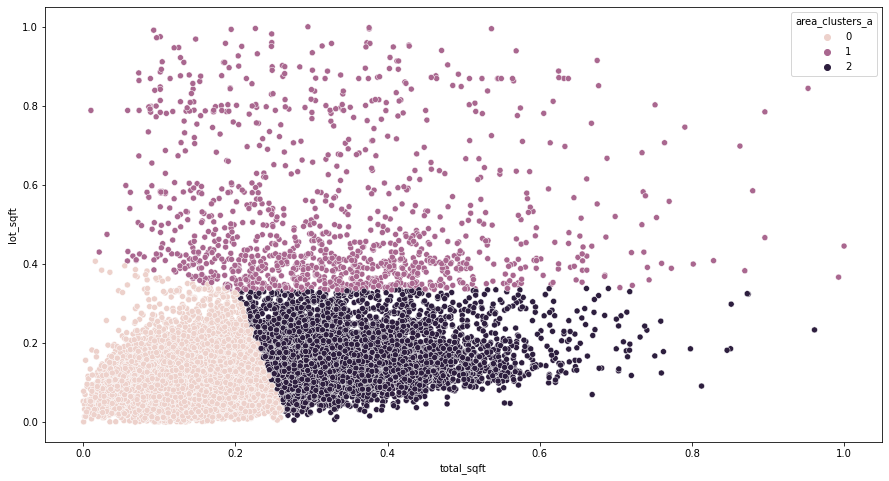

In [67]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='total_sqft', y='lot_sqft', hue='area_clusters_a', data=train)

In [69]:
# Set alpha
alpha = 0.05
cluster0 = train[train.area_clusters_a==0].logerror
cluster1 = train[train.area_clusters_a==1].logerror
cluster2 = train[train.area_clusters_a==2].logerror
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cluster0, cluster1, cluster2)
if p < alpha:
    print("We reject H0.")
    print(Fore.BLUE + '\nMean of 3 area clusters are not all equal. ')
else:
    print("We fail to reject H0")

We reject H0.

Mean of 3 area clusters are not all equal. 


<span style='background :yellow' >**Area: total_sqft, lot_sqft, k==4**</span>

In [70]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=4)
kmeans.fit(cluster_vars)
cluster_vars = train[['total_sqft', 'lot_sqft']]
area_clusters = kmeans.predict(cluster_vars)
train['area_clusters_b'] = area_clusters
train.groupby('area_clusters_b').logerror.mean()

area_clusters_b
0    0.014677
1    0.018912
2    0.024202
3    0.024980
Name: logerror, dtype: float64

<AxesSubplot:xlabel='area_clusters_b', ylabel='logerror'>

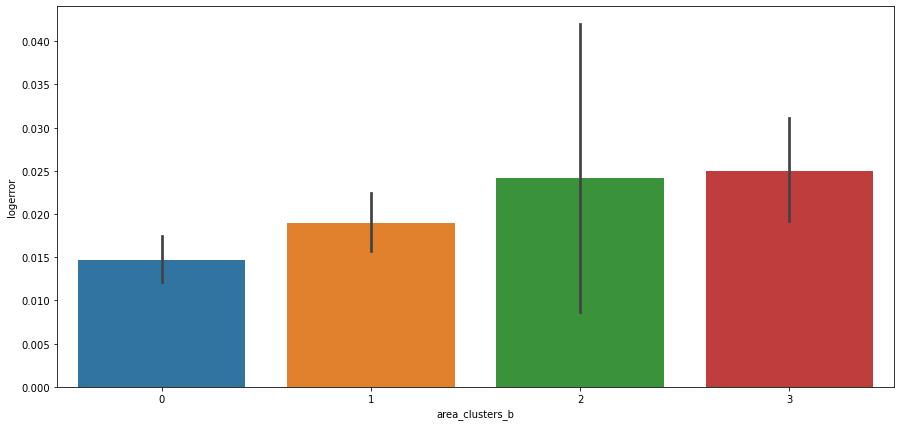

In [73]:
plt.figure(figsize = (15,7))
sns.barplot(x='area_clusters_b', y='logerror', data = train)

**NOTE: Cluster 2 and 3 hardly have any difference.We will pass on this cluster.**

<span style='background :red' >**Area: total_sqft, lot_sqft, living_sqft k==3**</span>

In [75]:
cluster_vars = train[['total_sqft', 'lot_sqft', 'living_sqft']]

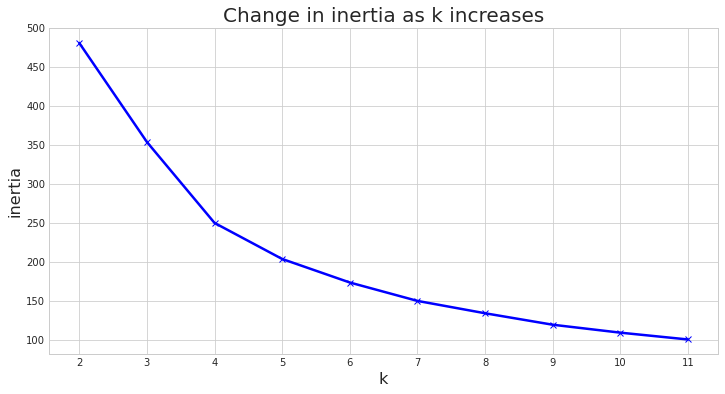

In [76]:
# Using the elbow method to visually select a good value for k.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 6))
    pd.Series({k: KMeans(k).fit(cluster_vars).inertia_ for k in range(2, 12)}).plot(marker='x', color = 'blue', linewidth = 2.5)
    plt.xticks(range(2, 12))
    plt.xlabel('k', fontsize = 16)
    plt.ylabel('inertia', fontsize = 16)
    plt.title('Change in inertia as k increases', fontsize = 20)

In [77]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_vars)
cluster_vars = train[['total_sqft', 'lot_sqft', 'living_sqft']]
area_clusters = kmeans.predict(cluster_vars)
train['area_clusters_c'] = area_clusters
train.groupby('area_clusters_c').logerror.mean()

area_clusters_c
0    0.029228
1    0.014924
2    0.022563
Name: logerror, dtype: float64

<AxesSubplot:xlabel='area_clusters_c', ylabel='logerror'>

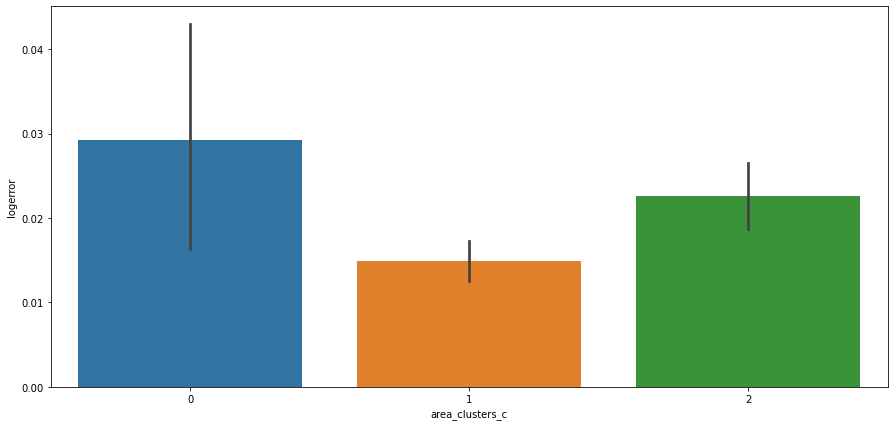

In [78]:
plt.figure(figsize = (15,7))
sns.barplot(x='area_clusters_c', y='logerror', data = train)

<span style='background :yellow' >**Area: total_sqft, lot_sqft, living_sqft k==4**</span>

In [79]:
# Create clusters and fit cluster model
kmeans = KMeans(n_clusters=4)
kmeans.fit(cluster_vars)
cluster_vars = train[['total_sqft', 'lot_sqft', 'living_sqft']]
area_clusters = kmeans.predict(cluster_vars)
train['area_clusters_d'] = area_clusters
train.groupby('area_clusters_d').logerror.mean()

area_clusters_d
0    0.018004
1    0.028556
2    0.014885
3    0.018273
Name: logerror, dtype: float64

<AxesSubplot:xlabel='area_clusters_d', ylabel='logerror'>

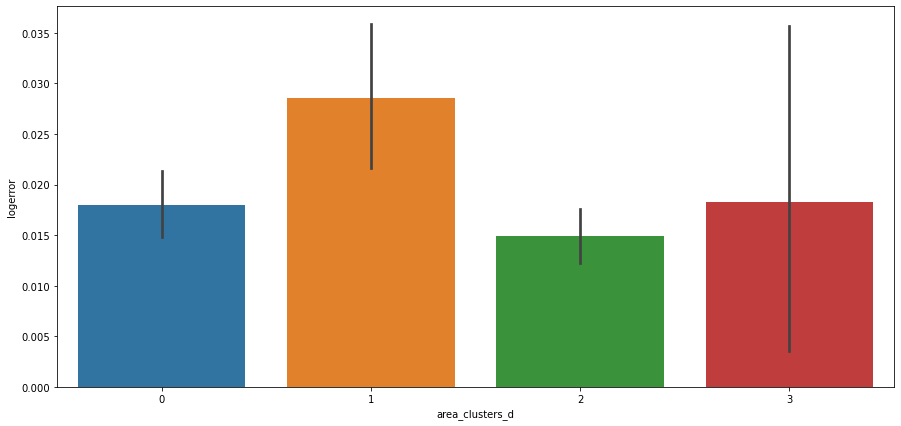

In [80]:
plt.figure(figsize = (15,7))
sns.barplot(x='area_clusters_d', y='logerror', data = train)